In [1]:
# !pip install rdflib
# !pip install load_dotenv
# !pip install faiss-cpu
# !pip install --upgrade langchain-ollama
# !pip install --upgrade langchain 
# !pip install --upgrade langchain-community

In [2]:
import os
import re
import pickle
from pprint import pprint
from dotenv import load_dotenv
from rdflib import Graph

In [3]:
from langchain_core.documents import Document
from langchain_ollama import OllamaEmbeddings
from langchain.chat_models import ChatOllama
from langchain_core.messages import AIMessage

In [4]:
import faiss
from uuid import uuid4
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

In [5]:
# Configuration files
ttl_file = "/Users/Ruben/Github/MoMuHackathon/Data/items_filtered.ttl"
pkl_file = "/Users/Ruben/Github/MoMuHackathon/Data/dataset.pkl"
txt_for_validation = "/Users/Ruben/Github/MoMuHackathon/Data/graph_output.txt"
docs_path = "/Users/Ruben/Github/MoMuHackathon/output_documents"

In [6]:
def convert_ttl_to_dict(ttl_file, pkl_file, txt_for_validation):
    out = dict()
    g = Graph()
    g.parse(ttl_file, format="turtle")
    json_ld_data = g.serialize(format="json-ld", indent=4)
    with open(txt_for_validation, "w") as file:
        # Iterate through each triple in the graph
        subjects = set(g.subjects())
        for subject in subjects:
            org_subject = subject
            if "api/item" in subject:
                subj_formalized = str(subject).split('/')[-1]
                if '#' in subj_formalized:
                    subject = subj_formalized.split('#')[-1]
                else:
                    subject = subj_formalized
                out[subject] = {}
                file.write(f"Subject {subject}\n")
                # Iterate over all triples where this subject is the subject
                for pred, obj in g.predicate_objects(subject=org_subject):
                    pred_formalized = str(pred).split('/')[-1]
                    if '#' in pred_formalized:
                        pred = pred_formalized.split('#')[-1]
                    else:
                        pred = pred_formalized
                    if "http" not in obj:
                        out[subject][pred] = str(obj)
                        file.write(f"{pred}: {obj}\n")
                     
    with open(pkl_file, "wb") as f:
        pickle.dump(out, f)
    
    return out

In [7]:
dataset = convert_ttl_to_dict(ttl_file, pkl_file, txt_for_validation)
# with open(pkl_file, "rb") as f:
#     dataset = pickle.load(f)

In [8]:
def simplify_predicate(predicate):
    match = re.search(r"[#/](\w+)$", predicate)
    return match.group(1).replace("_", " ") if match else predicate

In [9]:
def generate_readable_content_v2(instance, properties):
    lines = []
    instance_id = str(instance).split("/")[-1]  
    # lines.append(f"The item {instance_id} has the following information:")
    
    for predicate, obj in properties:
        simplified_predicate = simplify_predicate(str(predicate))
        if "is_public" in str(predicate):
            lines.append(f"The item {instance_id} is {'public' if obj == 'true' else 'not public'}.")
        elif "title" in str(predicate):
            lines.append(f"The identifier of this artifact is \"{obj}\".")
        elif "description" in str(predicate):
            lines.append(f"The description of this artifact is \"{obj}\"")
        elif "date" == str(predicate):
            # print (predicate, obj)
            lines.append(f"This artifact was created from the following period: {obj}.")
        elif "modified" in str(predicate):
            lines.append(f"This artifact was last modified on {obj}.")
        elif "medium" in str(predicate):
            lines.append(f"The medium of this artifact includes {obj}.")
        elif "extent" in str(predicate):
            lines.append(f"The dimensions of this artifact are {obj}.")
        elif "publisher" in str(predicate):
            lines.append(f"The publisher of this artifact is {obj}.")
        elif "subject" in str(predicate):
            lines.append(f"The subject of this artifact includes {obj}.")
        elif "shortDescription" in str(predicate):
            obj = obj.replace('\n', '')
            lines.append(f"The context of this artifact is \"{obj}\".")
        elif "P48_has_preferred_identifier" in str(predicate):
            lines.append(f"The preferred identifier of this artifact is {obj}.")
        elif "P50_has_current_keeper" in str(predicate):
            lines.append(f"The current keeper of this artifact is {obj}.")
        elif "P55_has_current_location" in str(predicate):
            lines.append(f"The current location of this artifact is in {obj}.")
        elif "dateSubmitted" in str(predicate):
            lines.append(f"This artifact was submitted on {obj}.")
        elif "identifierGroupType" in str(predicate):
            lines.append(f"The group type of this artifact is  {obj}.")
        elif "identifierGroupValue" in str(predicate):
            lines.append(f"The group value of this artifact is {obj}.")
        elif simplified_predicate == "id":
            continue
        else:     
            # print (simplified_predicate)
            lines.append(f"The {simplified_predicate} of this artifact is {obj}.")
    
    return lines

In [10]:
def convert_pkl_to_doc(dataset, docs_path, save_txt = True):

    docs = list()
    combined_texts = dict()
    for item, val in dataset.items():
        item_id = str(item).split("/")[-1]
        properties = [(k, v) for k,v in val.items()]
        # lines = generate_readable_content(item, properties)
        lines = generate_readable_content_v2(item, properties)
        for line in lines:
            docs.append (
                Document(
                page_content = line,
                metadata={'item_id': item_id}
                )
        )

        combined_texts[item_id] = '\n'.join(lines)
        
        if save_txt:
            file_name = item_id + ".txt"  
            file_path = os.path.join(docs_path, file_name)
            with open(file_path, "w", encoding="utf-8") as f:
                f.write('\n'.join(lines))
                
    return docs, combined_texts

In [11]:
docs, combined_texts = convert_pkl_to_doc(dataset, docs_path)

In [12]:
# https://python.langchain.com/docs/integrations/vectorstores/faiss/

# embeddings = OllamaEmbeddings(model="llama3.2:1b")
embeddings = OllamaEmbeddings(model="mxbai-embed-large")

index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

uuids = [str(uuid4()) for _ in range(len(docs))]
vector_store.add_documents(documents=docs, ids=uuids)

['2116e0d1-8ecb-40ab-8582-24de8d4ebf69',
 '7255e7cc-0bd7-444c-b2c2-df9f89326a59',
 '52471ac5-243b-4b07-ae57-ced1a6ea4566',
 '00522185-8a11-4374-beb8-a30de2b379ce',
 '2e1aec64-1301-4427-8a51-3b3e613fc8eb',
 '76b2634d-4077-4908-8514-26d32b9c3ea9',
 '2817878f-8d72-496b-bf64-62cbe90e0d65',
 '7f40ab81-6fce-410e-bd7d-7b4740f9c37f',
 '6d2d2f30-1349-442b-bb09-1859c5810fa6',
 '85df280f-1905-46cc-ade7-042195027182',
 'd8117267-7710-4a33-9349-49bae1204f05',
 'e9cec3e2-da56-49cb-a733-4fae4efbc171',
 '1a8624e9-d065-47e0-b02e-e014c39352da',
 '995f2050-e71a-45f2-b981-cff7e6135851',
 'a08281ef-0294-4153-ae5d-0082cb6338ba',
 'a3933fba-012b-4d99-a1bd-2369a605e230',
 '3a2d19a9-0d11-4cf5-bd3c-a398dca21d49',
 '17f763e7-8d71-4a9f-9155-804583561f62',
 '259fd78f-388d-4035-abac-53aa459c092b',
 '8dcce0d7-9231-4487-889c-d60cd88ac792',
 '7baba2ff-bb1b-4f87-bfd1-f85a3840313a',
 'd7ffb192-88dd-410c-b257-93f6b62c111c',
 'd81a8c20-32ff-4fec-b9af-da9f960defd6',
 '97258eb8-bbb2-4c21-bffe-7baa4652a71c',
 'f9c7ac59-cf02-

In [13]:
# TEST DEMO: Similarity search
results = vector_store.similarity_search(
    "What are the artefacts that are created in the 1900s",
    k=5,
    
)
for res in results:
    print(f"* {res.page_content} [{res.metadata}]")

* This artifact was created from the following period: 1900-1910. [{'item_id': '14641'}]
* This artifact was created from the following period: 1900-1909. [{'item_id': '16016'}]
* This artifact was created from the following period: ca. 1900. [{'item_id': '15938'}]
* This artifact was created from the following period: ca. 1900. [{'item_id': '16076'}]
* This artifact was created from the following period: 1850-1900. [{'item_id': '15966'}]


In [14]:
def chat_llm(llm, query, new_m=None, messages=None):
    # results = vector_store.similarity_search(
    #     query,
    #     k=1,
    #     # filter={"source": "tweet"},
    # )
    # for res in results:
    #     print(f"* {res.page_content} [{res.metadata}]")
    
    # retrieve the right artifact 
    # simply pick the top one
    item_id = results[0].metadata['item_id']
    context = combined_texts[item_id]
    messages = [
        (
            "system",
            f"You are a helpful assistant in museum to explain the artifact. \
            You have the knowledge about the artifact: {context}. \
            Please answer the question \
            and then introduce detailed information about this artifact, \
            Your answer must include the identifier, created period, and 3-4 sentences as its description ",
        ),
        ("human", query),
    ]
    
    
    ai_msg = llm.invoke(messages)
    print('-'* 30 + " Context of the Artifact " + '-'* 30)
    print(context)
    print('-'* 30 + " LLM answer " + '-'* 30)
    print(ai_msg.content)
    return messages, results

In [15]:
# https://python.langchain.com/docs/integrations/chat/ollama/
llm = ChatOllama(model="llama3.1", temperature=0)

C:\Users\Ruben\AppData\Local\Temp\ipykernel_34780\2463089884.py:2: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model="llama3.1", temperature=0)


In [16]:
query = "What can you tell me about the history of the artefact?"
chat_llm(llm, query)

------------------------------ Context of the Artifact ------------------------------
The identifier of this artifact is "ST80519".
This artifact was created from the following period: 1900-1910.
The description of this artifact is "Dunne, ecrukleurige, lange jas die tijdens het auto rijden over de kleding werd gedragen om deze te beschermen. De jas heeft een kleine kraag, lange mouwen, twee zakken vooraan en sluit vooraan met vijf knopen."
The medium of this artifact includes metaal.
The publisher of this artifact is MOMU.
The subject of this artifact includes jas.
The context of this artifact is "Dit type losse, lichtgewicht jas wordt ook wel ‘duster’ genoemd. Een duster wordt tijdens het autorijden over de kleding gedragen om deze onderweg tegen vuil en stof (‘dust’ in het Engels) te beschermen. De duster is een aanpassing van een soortgelijke jas die vanaf het einde van de achttiende eeuw werd gedragen voor reizen per paard of koets. Een duster was ruimvallend, reikte van nek tot k

([('system',
   'You are a helpful assistant in museum to explain the artifact.             You have the knowledge about the artifact: The identifier of this artifact is "ST80519".\nThis artifact was created from the following period: 1900-1910.\nThe description of this artifact is "Dunne, ecrukleurige, lange jas die tijdens het auto rijden over de kleding werd gedragen om deze te beschermen. De jas heeft een kleine kraag, lange mouwen, twee zakken vooraan en sluit vooraan met vijf knopen."\nThe medium of this artifact includes metaal.\nThe publisher of this artifact is MOMU.\nThe subject of this artifact includes jas.\nThe context of this artifact is "Dit type losse, lichtgewicht jas wordt ook wel ‘duster’ genoemd. Een duster wordt tijdens het autorijden over de kleding gedragen om deze onderweg tegen vuil en stof (‘dust’ in het Engels) te beschermen. De duster is een aanpassing van een soortgelijke jas die vanaf het einde van de achttiende eeuw werd gedragen voor reizen per paard of 

In [17]:
# TODO
# 1) improve the retrieval stage (acc & multi questions)
# 2) work on the system prompt to see what to display
# 3) backup the vector store 
# 4) reduce the inference time
# 5) introduce more metadata, e.g., image
# 6) multilingual feature

In [23]:
import requests
from PIL import Image
import io
import json

BASE = "https://heron.libis.be/momu/api/items/"


def image_retriever(item_id):
    full_url = BASE + str(item_id)
    response = requests.get(full_url)

    # Convert JSON-LD to TTL

    data_dict = json.loads(response.content)
    
    image = Image.open(io.BytesIO(requests.get(data_dict["thumbnail_display_urls"]["large"]).content))
    return image

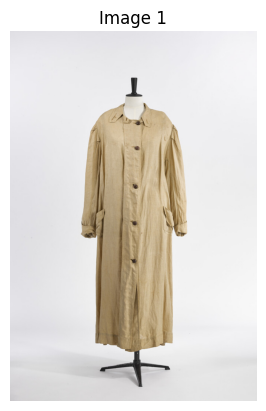

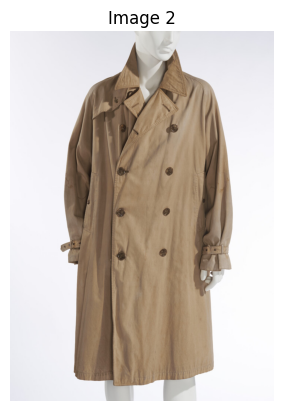

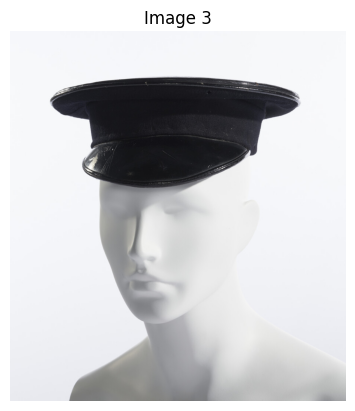

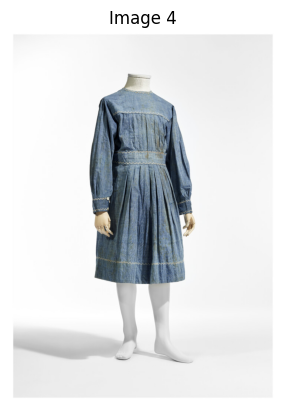

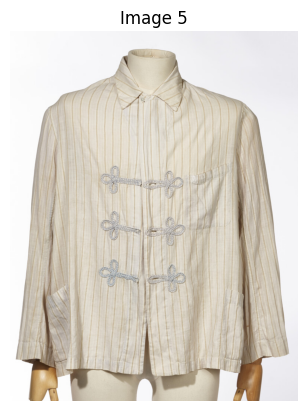

In [24]:
import matplotlib.pyplot as plt
images = [image_retriever(res.metadata['item_id']) for res in results]


for idx, img in enumerate(images):
    plt.figure()  # Create a new figure for each image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis for better visualization
    plt.title(f"Image {idx + 1}")
    plt.show()

* The description of this artifact is "Kinderjurkje van gele katoen; Peter Pan-kraagje afgewerkt met blauw garen; smokwerk ter hoogte van de borst afgewerkt met blauw en geel garen; kleine bloemetjes in dezelfde kleuren op de gerimpelde rok. Korte pofmouwtjes. Sluit aan de achterzijde met drie drukknopen, aan de buitenkant is de sluiting afgewerkt met doorzichtige kunststof knopen met reliëf, die opgebouwd zijn uit kleine bolletjes. Netjes uitgevoerd handwerk." [{'item_id': '15706'}]


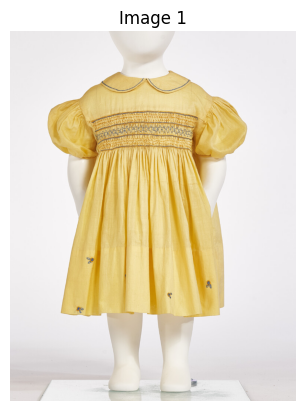

* The context of this artifact is "Een Peter Pan-kraag is een platvallende, tweedelige ronde kraag die vanaf ongeveer 1909 modieus werd, hoewel gelijkende kragen al in de negentiende eeuw onder andere namen bestonden. De naam is afkomstig van de hoofdrolspeler uit het gelijknamige toneelstuk (première in 1904) en boek (1911) geschreven door de Schotse auteur J. M. Barrie. Actrice Maude Adams droeg een kostuum met een dergelijke kraag toen zij in 1905 de rol van Peter Pan vertolkte op het Amerikaanse Broadway. De Peter Pan kraag was vooral geliefd als onderdeel van kleding voor jonge meisjes en kleine kinderen en werd dan ook gedurende de rest van de twintigste eeuw gedragen.". [{'item_id': '15706'}]


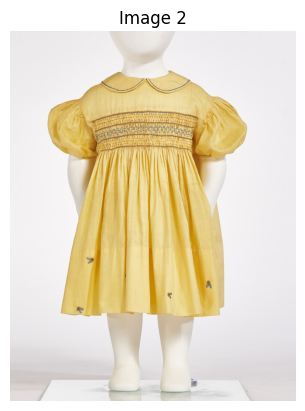

* The description of this artifact is "Pak, Eton-pak, met zwart gilet en jacquet, grijze gestreepte broek en wit hemd met aparte stijve kraag (ronde Eton-kraag) en manchetten.   A. kort jacquet in zwarte wol, met satijnen revers en voering, zwarte kunststof knopen   B. gilet in zwarte wol   C. broek in grijze gestreepte wol   D. wit katoen hemd   E. wit katoen stijve ronde kraag   FG. witte katoenen stijve manchetten" [{'item_id': '15766'}]


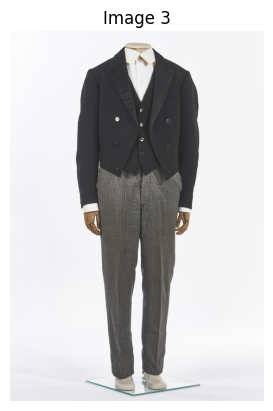

* The description of this artifact is "Platte pet, behorende tot een uniform, van donkerblauwe lakense wol. Bovenzijde van kap bestaande uit een cirkel van donkerblauw gelakt imitatieleder. Maanvormige klep van idem imitatieleder. Binnenzijde is bekleed met doorgestikte zwarte zijde in keperbinding met fijne streepjes. Goudkleurig strikje aan achterzijde hoofd." [{'item_id': '15938'}]


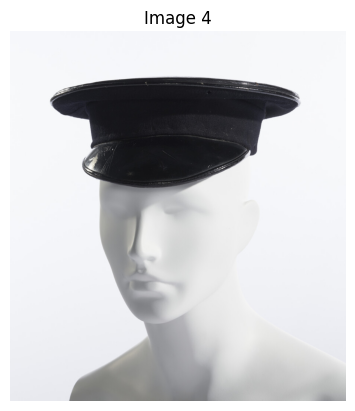

* The description of this artifact is "Spijkerbroek, zogenaamde type bell-bottoms, van donkerblauwe katoenen spijkerstof. Tailleband van dezelfde stof met riemlusjes. Aan de voorzijde op heuphoogte versierd met machinaal geborduurde gestileerde bloemen in gele, groene en paarse katoen. Lange, vanaf de knie wijd uitlopende pijpen. Twee opgestikte zakken op het achterwerk. Sluiting middenvoor door middel van twee paarse plastic knopen (één knoop ontbreekt en één is vervangen door een zwarte plastic knoop) en een grote metalen drukknoop bovenaan." [{'item_id': '15950'}]


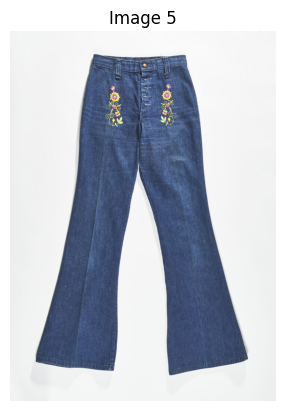

In [29]:
# TEST DEMO: Similarity search
results = vector_store.similarity_search(
    "What are the artefacts that are related to peter pan",
    k=5,
    
)
for idx, res in enumerate(results):
    print(f"* {res.page_content} [{res.metadata}]")
    img = image_retriever(res.metadata['item_id'])
    plt.figure()  # Create a new figure for each image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis for better visualization
    plt.title(f"Image {idx + 1}")
    plt.show()